# Car Evaluation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [2]:
seed = 777

## Read Data

In [3]:
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(os.path.join("data", "car.data"), names=columns, header=None, index_col=False)

`persons` is not a feature used for prediction

In [4]:
df = df.drop(["persons"], axis=1)

In [5]:
df.head()

,buying,maint,doors,lug_boot,safety,class
0,vhigh,vhigh,2,small,low,unacc
1,vhigh,vhigh,2,small,med,unacc
2,vhigh,vhigh,2,small,high,unacc
3,vhigh,vhigh,2,med,low,unacc
4,vhigh,vhigh,2,med,med,unacc


verify that `class` value distribution is as described

In [6]:
round(df["class"].value_counts() / len(df["class"]) * 100, 3)

unacc    70.023
acc      22.222
good      3.993
vgood     3.762
Name: class, dtype: float64

In [7]:
df.describe()

,buying,maint,doors,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,4
top,low,low,2,big,low,unacc
freq,432,432,432,576,576,1210


## Ordinal Encoding

In [8]:
categories = {
    "buying": ["low", "med", "high", "vhigh"],
    "maint": ["low", "med", "high", "vhigh"],
    "doors": ["2", "3", "4", "5more"],
    "lug_boot": ["small", "med", "big"],
    "safety": ["low", "med", "high"],
    "class": ["unacc", "acc", "good", "vgood"]
}

In [9]:
for c in categories:
    cat = pd.Categorical(df[c], categories=categories[c], ordered=True)
    df[c] = pd.DataFrame(pd.factorize(cat, sort=True)[0])

In [10]:
df.head()

,buying,maint,doors,lug_boot,safety,class
0,3,3,0,0,0,0
1,3,3,0,0,1,0
2,3,3,0,0,2,0
3,3,3,0,1,0,0
4,3,3,0,1,1,0


## Feature Selection

<AxesSubplot:>

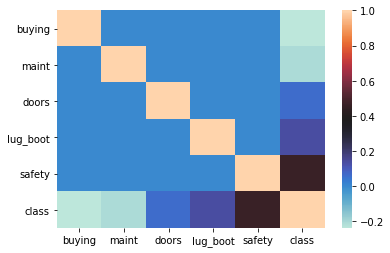

In [11]:
sns.heatmap(df.corr(method="spearman"), cmap="icefire")

From the heatmap plot, it is obvious that the `buying` variable is not correlated to any variable except for the variable `class`, albeit weakly (negatively) correlated. Hence, we will only use the class value variable to predict the buying price of a car, the other variables will only introduce noise in the resulting machine learning model if used.

In [12]:
df = df[["buying", "class"]]

## Undersampling

In [13]:
sample_size = min(df["class"].value_counts())

Choose from each category in `class` the same number of samples

In [14]:
np.random.seed(seed)
chosen = np.array([], dtype=np.int)
for c in categories["class"]:
    i = categories["class"].index(c)
    chosen = np.append(chosen, np.random.choice(df[df["class"] == i].index, sample_size, replace=False))

In [15]:
df.loc[chosen].head()

,buying,class
1411,0,0
1333,0,0
417,3,0
1342,0,0
963,1,0


## Modeling

In [16]:
X = df.loc[chosen][["class"]]
y = df.loc[chosen][["buying"]]

In [17]:
clf = LogisticRegression()

k-fold cross validation

In [18]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

In [19]:
scores = cross_val_score(clf, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

In [20]:
print("Average accuracy obtained from cross validation:", round(np.mean(scores), 3))

Average accuracy obtained from cross validation: 0.496


## Prediction

In [21]:
clf.fit(X, np.ravel(y))

LogisticRegression()

Tasked to predict class value of "good"

In [22]:
index = categories["class"].index("good")

In [23]:
prob = clf.predict_proba([[index]])[0]
for i, b in enumerate(categories["buying"]):
    print(f"prob. of {b}: {prob[i]:.3f}")

prob. of low: 0.597
prob. of med: 0.350
prob. of high: 0.024
prob. of vhigh: 0.029


In [24]:
pred = categories["buying"][clf.predict([[index]])[0]]
print("The predicted buying price is:", pred)

The predicted buying price is: low
